# Practical SVD System ID

Consider the following discrete-time system:
$$x[i+1] = a x[i] + b_1 u_1[i] + b_2 u_2[i]$$
for some unknown system parameters $a, b_1, b_2$. We can estimate the unknown parameters by setting up a system of linear equations and solving it, namely
$$D \vec{p} = \vec{s}$$
where $\vec{p} = \begin{bmatrix} a \\ b_1 \\ b_2 \end{bmatrix}$ contain our unknown parameters.
Previously, we discussed that if $u_2[i] = \alpha u_1[i]$ for some constant $\alpha \in \mathbb{R}$, then we cannot use our traditional least squares approach for performing system ID. Since $D \in \mathbb{R}^{m \times n}$ would not have full column rank in this case, we have to resort to other methods for estimating $\vec{p}$. From the previous homework, we know how to apply the SVD to solve this problem assuming $\mathrm{rank}(D) < \min(m, n)$. Let us apply this approach here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

Below, we define some inputs which we will use to identify the system. Notice that we set $u_2[i] = 2 u_1[i]$.

In [2]:
u1_inp = np.array([1, -1, 2, 3, 2, 2, 1, -2, 5])
u2_inp = 2*u1_inp
x0 = 0

Next, we will generate data by applying inputs to our system and observing the states. Our actual system parameters are $a = 0.5, b_1 = -2, b_2 = 3$. Let's see how close our solution gets to these actual parameters.

In [3]:
def generate_data(x0, u1_inp, u2_inp):
    xs = [x0]
    for i in range(len(u1_inp)):
        x_next = 0.5*xs[-1] - 2*u1_inp[i] + 3*u2_inp[i] + np.random.normal()
        xs.append(x_next)
    return np.array(xs)

In [4]:
xs = generate_data(x0, u1_inp, u2_inp)

In [5]:
xs = np.expand_dims(xs, axis=1)
u1_inp = np.expand_dims(u1_inp, axis=1)
u2_inp = np.expand_dims(u2_inp, axis=1)

__First, define our $D$ matrix and $\vec{s}$ vector using the generated data.__ The numpy array `xs` has data arranged like $\begin{bmatrix} x[0] \\ x[1] \\ \vdots \\ x[9] \end{bmatrix}$, the numpy array `u1_inp` has data arranged like $\begin{bmatrix} u_1[0] \\ u_1[1] \\ \vdots \\ u_1[8] \end{bmatrix}$, and the numpy array `u2_inp` has data arranged like $\begin{bmatrix} u_2[0] \\ u_2[1] \\ \vdots \\ u_2[8] \end{bmatrix}$

HINT: You may find the following function useful: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html

In [6]:
D = np.hstack((xs[:-1], u1_inp, u2_inp))
s = xs[1:]

We expect $D$ to have dimensions $9 \times 3$. __Use the cell below to confirm that. Then, compute the rank of $D$.__ Make sure it matches with what you expect for our choice of inputs.

HINT: You may find the following function useful: https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html

In [7]:
m, n = D.shape
r = np.linalg.matrix_rank(D)
print(f'Dimensions of D: {m} by {n}')
print('Rank of D:', r)

Dimensions of D: 9 by 3
Rank of D: 2


__Next, write code to compute the SVD of $D$.__ Let $U$ be denoted with `U`, $\Sigma$ be denoted with `Sig`, and $V$ be denoted with `V`.

HINT: You may find the following functions useful: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html, https://numpy.org/doc/stable/reference/generated/numpy.diag.html. Take careful note of the outputs of `np.linalg.svd`.

In [8]:
U, Sig, Vt = np.linalg.svd(D)
Sig = np.diag(Sig)
V = Vt.T

__Using the previous cell, write code to find $U_r$ (denoted `U_r`) and $\Sigma_r$ (denoted `Sig_r`).__

In [9]:
U_r = U[:,:r]
Sig_r = Sig[:r,:r]

From the previous homework, we know that
$$\vec{p}_{\star} = V \begin{bmatrix} \Sigma_r^{-1} U_r^\top \vec{s} \\ \vec{0}_{n-r} \end{bmatrix}$$
is the lowest-norm choice of $\vec{p}$ that minimizes $\lVert D \vec{p} - \vec{s} \rVert$. __Write this solution in code (where $\vec{p}_{\star}$ is denoted by `p_star`). Are the values of $a, b_1, b_2$ what you expect? Why or why not?__

HINT: You may find the following functions useful: https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html, https://numpy.org/doc/stable/reference/generated/numpy.vstack.html

__Solution:__

*The value of $a$ that we see is close to the true value of $a$ (0.5). This is because there is no linear dependence of the first column of $D$ on any of the rest of the columns. However, there is linear dependence between the second and third columns of $D$ which is why the values of $b_1$ and $b_2$ are not close to the true value. While there might be some quantity close to the true value that still minimizes $\lVert D \vec{p} - \vec{s} \rVert$, it is not the minimum norm solution.*

In [10]:
p_star = V @ np.vstack((np.linalg.inv(Sig_r) @ U_r.T @ s, np.zeros((n-r,1))))
print("optimal p", p_star)
print("norm of p", np.linalg.norm(p_star))

optimal p [[0.475805  ]
 [0.80410947]
 [1.60821895]]
norm of p 1.8599329605723247


We can see how closely our estimated system's trajectory follows the true system's trajectory:

In [11]:
def plot_trajectory_vs_ground_truth(p_star, u1_inp, u2_inp, x0):
    xs_gt = [x0]
    xs_est = [x0]
    a_star = p_star[0,0]
    b_1_star = p_star[1,0]
    b_2_star = p_star[2,0]
    for i in range(len(u1_inp)):
        x_next = 0.5*xs[-1] - 2*u1_inp[i] + 3*u2_inp[i]
        xs_gt.append(x_next)
        x_next_est = a_star*xs_est[-1] + b_1_star*u1_inp[i] + b_2_star*u2_inp[i]
        xs_est.append(x_next_est)
    plt.plot(xs_gt, label="Ground Truth Trajectory")
    plt.plot(xs_est, label="Estimated Trajectory")
    plt.legend(loc="best")

/opt/conda/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


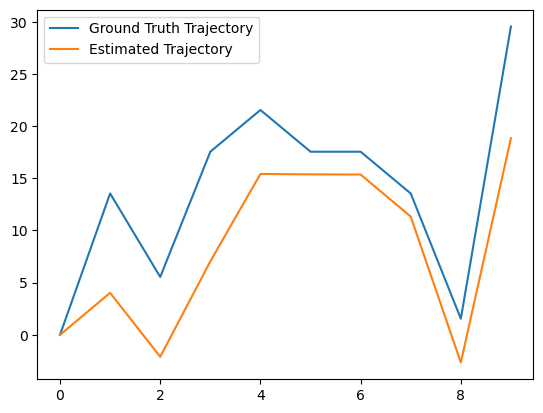

In [12]:
plot_trajectory_vs_ground_truth(p_star, u1_inp, u2_inp, 0)

We can try replacing the vector of zeros ($\vec{0}_{n-k}$) with another arbitrary vector $\vec{k} \in \mathbb{R}^{n-k}$ (denoted `random_k`). That is, we can find
$$\vec{\widetilde{p}} = V \begin{bmatrix} \Sigma_r^{-1} U_r^\top \vec{s} \\ \vec{k} \end{bmatrix}$$
__Will using the values of $a, b_1, b_2$ in $\vec{\widetilde{p}}$ instead of $\vec{p}$ change the trajectory of the system for the given inputs? Why or why not? Fill in the code below to verify your answer.__



__Solution:__

*If we were to use the definition of $\vec{\widetilde{p}}$ and write out $V = \begin{bmatrix} V_r & V_{n-r} \end{bmatrix}$, we can perform block matrix multiplication to write
$$\vec{\widetilde{p}} = V_r \Sigma_r^{-1} U_r^\top \vec{s} + V_{n-r} \vec{k}$$ Notice that, when left multiplied by $D$, the $V_{n-r} \vec{k}$ becomes $\vec{0}_n$ since $V_{n-r} \vec{k} \in \mathrm{Null}(D)$. Hence, the value of $\vec{k}$ should not change the estimated trajectory.*

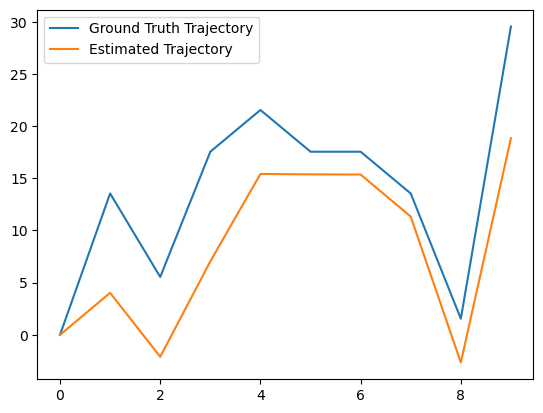

In [13]:
random_k = np.random.randn(n-r, 1)
p_tilde = V @ np.vstack((np.linalg.inv(Sig_r) @ U_r.T @ s, random_k))
plot_trajectory_vs_ground_truth(p_tilde, u1_inp, u2_inp, 0)

We can observe this phenomenon more generally by testing several random vectors in place of $\vec{0}_{n-k}$. First, we generate a large set of arbitrary $\vec{k}$ vectors. We can compute the highest loss (i.e., the highest value of $\lVert D \vec{\widetilde{p}} - \vec{s} \rVert$) among all randomly generated $\vec{k}$, and we can look at the lowest norm (i.e., the lowest value of $\lVert \vec{\widetilde{p}} \rVert$) among all randomly generated $\vec{k}$. __What do you expect for each of these quantities (i.e., for $\lVert D \vec{\widetilde{p}} - \vec{s} \rVert$ and $\lVert \vec{\widetilde{p}} \rVert$)? Fill in the code below to verify your answer.__



__Solution:__

*We expect the lowest norm to be at least $\lVert \vec{p}_{\star} \rVert$, and we expect the highest loss to be exactly $\lVert D \vec{p}_{\star} - \vec{s} \rVert$*

In [14]:
def insert_random_vectors(num_trials=100, rand_k_range=5):
    highest_loss = -float('inf')
    lowest_norm = float('inf')
    for _ in range(num_trials):
        random_k = rand_k_range*np.random.randn(n-r, 1)
        p_test = V @ np.vstack((np.linalg.inv(Sig_r) @ U_r.T @ s, random_k))
        highest_loss = max(highest_loss, np.linalg.norm(D @ p_test - s))
        lowest_norm = min(lowest_norm, np.linalg.norm(p_test))
    return highest_loss, lowest_norm

In [15]:
highest_loss, lowest_norm = insert_random_vectors()
print("highest loss", highest_loss)
print("lowest norm", lowest_norm)

highest loss 3.7040159978284977
lowest norm 1.8610105909069268
